# 🏥 Insurance prices 💰

Read more about dataset from [this kaggle page](https://www.kaggle.com/mirichoi0218/insurance).  The original source of the data is not mentioned in the description :(

We'll be predicting charges based on some features of the clients.

## General EDA and Viz

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

data_url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
insurance = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

Do some general eda to get familiar with what data we have.

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<IPython.core.display.Javascript object>

In [4]:
# Converting binary columns to 1s and 0s
insurance["smoker"] = (insurance["smoker"] == "yes").astype(int)
insurance["sex"] = (insurance["sex"] == "male").astype(int)

<IPython.core.display.Javascript object>

In [5]:
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<IPython.core.display.Javascript object>

In [6]:
insurance.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region       object
charges     float64
dtype: object

<IPython.core.display.Javascript object>

We can start our visualization journey with a `scatter_matrix` or an `sns.pairplot` to see all our continuous variables.  Categorical variables we might plot individually with our target since we have a managable number of columns.

* Create a `scatter_matrix` or an `sns.pairplot` of the data
* Note any correlations, patterns, and distributions you see

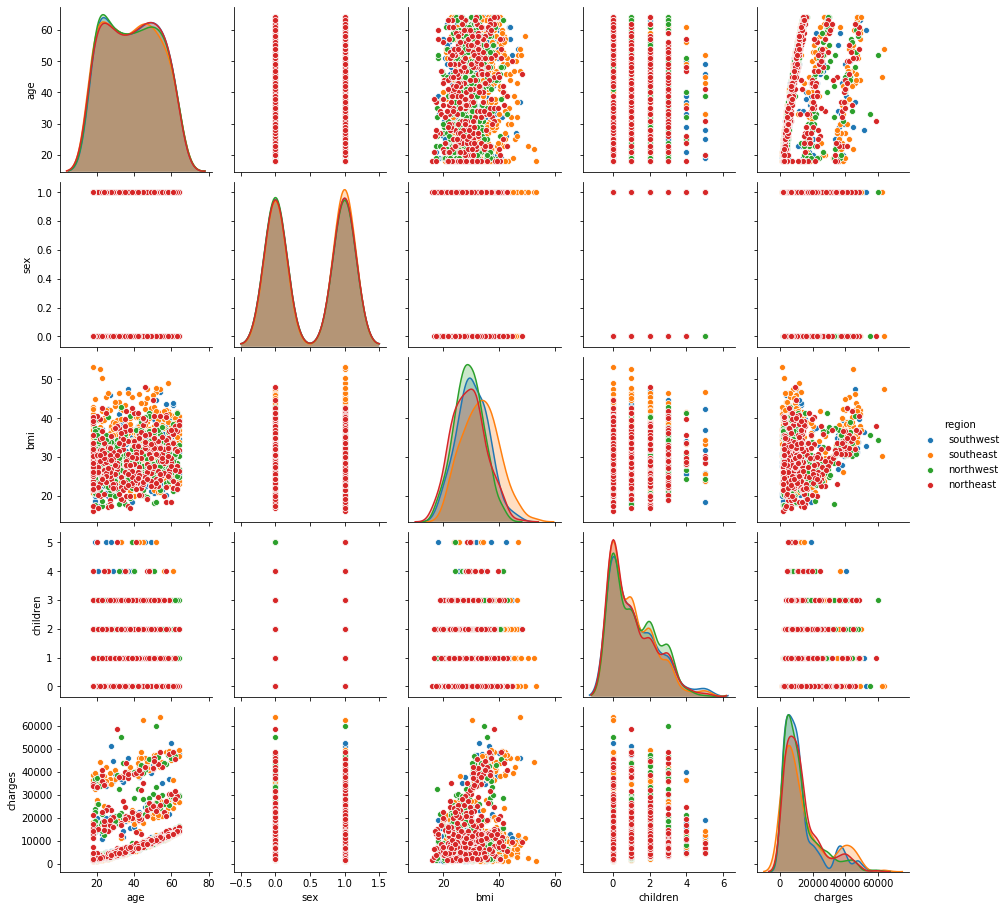

<IPython.core.display.Javascript object>

In [7]:
sns.pairplot(insurance.drop("smoker", 1), hue="region")
plt.show()

There's an interesting pattern in the scatterplot between `'age'` and `'charges'`.  It looks like there's 3 distinct groups.  This is hinting that there might be some variable interacting with `'age'`.  That is, the effect of `'age'` on `'charges'` might change based on some other variable at play.

Hopefully we can find this interacting variable in our data.  However, it might be explained by a variable outside of our dataset; some domain knowledge would then be very useful to try and bring what explains these gaps.

Let's visualize our categorical variables and try to figure out what might explain this.

* Create a for loop that iterates over all of the categorical columns
* Create a violin plot for each column with our `'charges'` column
* Interpret what you see

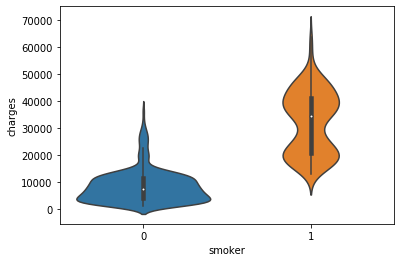

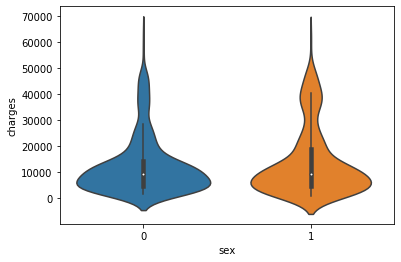

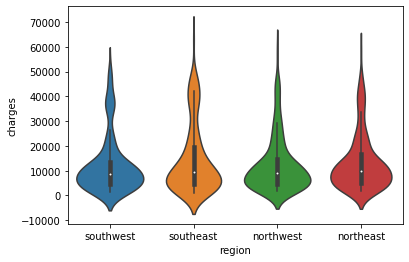

<IPython.core.display.Javascript object>

In [8]:
cat_cols = ["smoker", "sex", "region"]

for col in cat_cols:
    sns.violinplot(col, "charges", data=insurance)
    plt.show()

* Smokers definitely appear to be charged more than non-smokers
* The distributions between the sexes are pretty similiar.  The main difference is that the male distribution has a 'fatter' right hand tail (i.e. a group of males getting charged more)
* Region seems to have a very small effect on charges.  Perhaps the southeast has a fatter tail than the others, but this may be less due to region itself, and more explained by other variables.  For example, I think I've read that the southeast has some of the highest rates of obesitity, idk if this is still accurate (or if it ever was).

We just saw some effects that might help us explain the weird patterns shown in the `'age'` x `'charges'` scatter plot.  Let's try to include smoker in a scatterplot with these 2 variables since it appears to have the most extreme effect.

* Create a `scatterplot` of `'age'` and `'charges'` colored by the `'smoker'` column
* What do you notice?

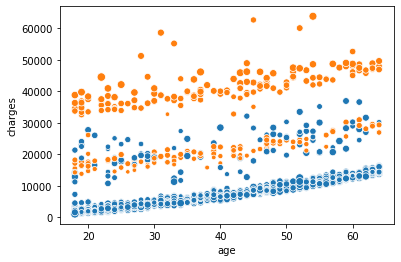

<IPython.core.display.Javascript object>

In [9]:
sns.scatterplot("age", "charges", hue="smoker", size="bmi", data=insurance)
plt.legend().remove()
plt.show()

It looks like being a smoker interacts with age to explain part of this pattern of groups.  The effect of age on charges changes depending on whether or not the individual is a smoker.

This plot shows that being a smoker could explain the top and bottom groups, but what about the middle group?  It looks like there's still a pattern to be found.

The remaining bit of the pattern is a little bit harder to discover.  We're already showing 3 dimensions in our 2d plot thanks to color.  We could include a sizing dimension to try and bring in a 4th dimension, but this is harder to interpret.

* Add the `'bmi'` column to the scatter plot using the `size` argument of `sns.scatterplot`

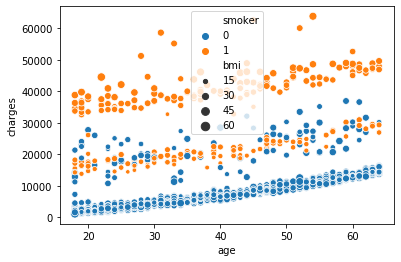

<IPython.core.display.Javascript object>

In [10]:
sns.scatterplot("age", "charges", hue="smoker", size="bmi", data=insurance)
plt.show()

Putting `'bmi'` looks to explain away some of the pattern as well. It's less obvious, but it looks like lower bmi smokers are in the middle group, while higher bmi smokers are in the top group.  There are exceptions to this though.  If I was a data scientist working on this problem I would want to discuss this plot with my clients to make sure I have all the features that account for these 3 'strips' of data.

## Model Prep

We'll keep all our features for now.  We might consider dropping region since it seems to have little effect based on our plots, but we would want to consult with experts (or build model with and without it and see if it has a positive effect on the accuracy or if its just dead weight).

In [11]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


<IPython.core.display.Javascript object>

In [12]:
bin_cols = ["sex", "smoker"]

cat_cols = ["region"]
drop_cats = ["southeast"]
# dropped it off of value counts (highest amount)

num_cols = ["age", "bmi", "children"]

<IPython.core.display.Javascript object>

In [38]:
X = insurance.drop(columns="charges")
y = np.log(insurance["charges"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

* Finish the `ColumnTransformer()` definition

In [39]:
preprocessing = ColumnTransformer(
    [
        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)


<IPython.core.display.Javascript object>

* Finish the `PipeLine()` definition using `SVR()`

In [40]:
# fmt: off
pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('svr', SVR(kernel='linear'))
    ],
)
# fmt: on


<IPython.core.display.Javascript object>

Math break

OLS tries to minimze the sum of squared errors (minmize mistakes and penalize big mistakes a little extra):
$$min \sum_{i=1}^{n}(y_i - (w^Tx_i + b))^2$$ 

* $w$ is the coefficients
* $x_i$ is a training sample (aka feature vector; aka row of `X`)
* $y_i$ is a training sample's true value
* $b$ is the intercept

SVR tries to minimize the coefficients and ensure every single observation lies within the 'tube' of error we say its allowed to have (defined by epsilon).  In real cases, we need some slack, not every observation will be in the tube.  Just like in `SVC` we say how much we care about mistakes (here a mistake is falling outside of the tube) using the parameter `C`.  Below is how we can think of the formulation of the problem. **This is not the actual formulation**, but I think it's a useful view of it for more thorough math see [here](http://kernelsvm.tripod.com/).

$$min \frac{1}{2}||w||^2 + C \sum_{i=1}^{n}\xi_i$$

If $|y_i - (w^Tx_i + b)| \le epsilon$ then we don't count it in the error term in the above formula (that is $\xi_i = 0$).

If $|y_i - (w^Tx_i + b)| > epsilon$ then we do count it in the error term in the above formula (that is $\xi_i > 0$).

* $w$ is the coefficients
* $x_i$ is a training sample (aka feature vector; aka row of `X`)
* $y_i$ is a training sample's true value
* $b$ is the intercept
* $\xi$ is a measure of error (called slack)

* Fit the pipeline to the training data
* Score the model on train and testing data
    * What is this score?
    * Do we want to minimize it or maximize it?

In [41]:
pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.7364468857431659
test_score: 0.7994366162076988


<IPython.core.display.Javascript object>

In [42]:
y_pred = pipeline.predict(X_test)
resid = y_pred - y_test

np.mean(np.abs(resid))

0.23500920613521295

<IPython.core.display.Javascript object>

Dang, that's horrible... Maybe we want a different `kernel`, maybe we want a different `C`, a different `epsilon`. Sounds easier to `GridSearchCV` for this than to do a lot of guess and check.

* Define a dictionary of parameters to be our grid to search through
    * Use `0.1`, `1`, & `10` for the potential values of `'epsilon'`
      * To specify parameters in a pipeline we have to provide the name of the step they apply to.  We specify the name of the step and then 2 underscores before using the usual hyperparameter name.  For example, if you named the `SVR()` step in your `Pipeline` `'svm'`, then the parameter name for `'epsilon'` would be `'svm__epsilon'`.
    * Try some of the kernels
    * Try a couple different degree polynomials
    * Note how many models you'll be building before running the grid search
* Define the grid search by passing in the pipeline, parameter grid
* Fit the grid search.
* Print out the best parameters.
    * Remember that `degree` is ignored by all `kernel`s except `'poly'`.  So if the best kernel isn't `'poly'` we can ignore the `degree` parameter chosen.

In [45]:
grid = {
    "svr__epsilon": [0.1, 1, 10],
    "svr__C": [0.01, 0.1, 1, 10],
    "svr__kernel": ["rbf", "linear"],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

print("Best hyperparameters:")
pipeline_cv.best_params_

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Best hyperparameters:


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.2s finished


{'svr__C': 1, 'svr__epsilon': 0.1, 'svr__kernel': 'rbf'}

<IPython.core.display.Javascript object>

* Score the resulting model that was fit via grid search cross validation
* If the fit is poor, take note of what hyperparameters were chosen, are any of them at the edges of the grid?  Adjusting the grid might improve fit.

In [46]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.8366162691655306
test_score: 0.8547772607425769


<IPython.core.display.Javascript object>

* Make predictions on the test set
* Calculate the mean absolute error (MAE) and the mean absolute percent error (MAPE)
* Create a plot of the fitted vs the actual values

In [47]:
y_pred = pipeline_cv.predict(X_test)

resid = y_pred - y_test
np.mean(np.abs(resid))

0.16525727181743372

<IPython.core.display.Javascript object>

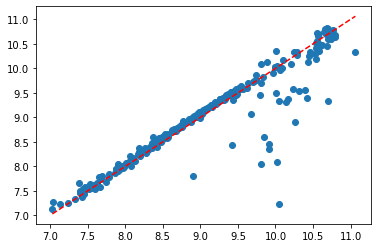

<IPython.core.display.Javascript object>

In [51]:
mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], "--", color="r")